In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random, sys
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves
from sklearn import metrics

2022-11-24 18:43:10.782283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-11-24 18:43:10.782315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
t = time.time()
path  = r'/rfs/CAPAI_PhD_dflr2/Shared/Data/output/20220221_'
#file1 = path + 'admissions.txt' 
file2 = path + 'eobs.txt'
file3 = path + 'haem-results.txt'
#file4 = path + 'icu.txt'
file5 = path + 'meds.txt'
file6 = path + 'micro-results.txt'
file7 = path + 'oxygen.txt'
file8 = path + 'prev_admissions.txt'
file9 = path + 'spin.txt'
#df_admin = pd.read_csv(file1, sep='\t', lineterminator='\n')
#df_eobs  = pd.read_csv(file2, sep='\t', lineterminator='\n')
#df_haemt = pd.read_csv(file3, sep='\t', lineterminator='\n')
#df_icu   = pd.read_csv(file4, sep='\t', lineterminator='\n')
#df_meds  = pd.read_csv(file5, sep='\t', lineterminator='\n')
#df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')
#df_oxyge = pd.read_csv(file7, sep='\t', lineterminator='\n')
#df_prev  = pd.read_csv(file8, sep='\t', lineterminator='\n')
df_spin  = pd.read_csv(file9, sep='\t', lineterminator='\n')

In [3]:
##################################################################
# PRE-PROCESSING DF SPIN
##################################################################
print(len(df_spin))
df_new = df_spin[df_spin['curb65_recorded'] == 'Y'].copy()
df_new['date_time_arrived'] = pd.to_datetime(df_new['date_time_arrived'].copy(), format='%Y-%m-%d %H:%M:%S')
df_new = df_new[~df_new['curb65_score'].isna()]
df_new = df_new.drop_duplicates(subset=['date_time_arrived', 'cxr_date', 'curb65_score'])
print(len(df_new))
display(df_new.head(5))

6761
4365


,patient_id,date_time_arrived,cxr_4h,cxr_cap,cxr_date,cxr_time,o2_1h,o2_prescribed_1h,curb65_recorded,curb65_score,ab_4h,reason_ab_not_concordant,ab_severity,ab_date_time\r
0,45502669,2019-01-02 15:46:00,Y,Y,2019-01-02,16:14,Y,N,Y,0.0,Y,NaN,Y,2019-01-02 17:00:00\r
1,70844377,2019-01-03 11:47:00,N,Y,2018-12-31,11:54,Y,N,Y,0.0,Y,2.0,Y,2019-01-03 14:00:00\r
2,43194461,2019-01-02 10:15:00,Y,Y,2019-01-02,10:31,Y,N,Y,0.0,Y,2.0,Y,2019-01-02 12:20:00\r
3,31229217,2019-01-01 05:28:00,Y,Y,0000-00-00,NaN,Y,Y,Y,1.0,Y,NaN,Y,2019-01-01 06:10:00\r
4,33092249,2019-01-02 03:58:00,N,Y,2018-01-02,13:55,Y,N,Y,1.0,N,NaN,Y,2019-01-02 17:30:00\r


In [4]:
df_new.isna().sum()

patient_id                     0
date_time_arrived              0
cxr_4h                        40
cxr_cap                       52
cxr_date                       0
cxr_time                      48
o2_1h                         91
o2_prescribed_1h             142
curb65_recorded                0
curb65_score                   0
ab_4h                         88
reason_ab_not_concordant    2633
ab_severity                   64
ab_date_time\r                 0
dtype: int64

,patient_id,curb65_score,reason_ab_not_concordant
count,4.365000e+03,4365.000000,1732.000000
mean,5.006262e+07,1.634135,2.006351
std,2.862511e+07,1.134081,0.153771
min,4.379000e+03,0.000000,1.000000
25%,2.508113e+07,1.000000,2.000000
50%,5.023081e+07,2.000000,2.000000
75%,7.454305e+07,2.000000,2.000000
max,9.996493e+07,5.000000,4.000000


0

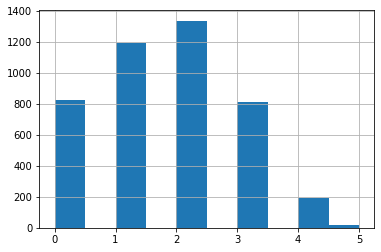

In [5]:
display(df_new.describe())
df_new['curb65_score'].hist()
df_new['curb65_score'].isna().sum()

In [6]:
path = r'/home/d/dlr10/Documents/01_Preprocessing/00_Data_2019_2020/DataFrame_pickles'
data_19_20 = pickle.load(open(path + r'/df_patients_admissions_2019_2020.pickle','rb'))
df_patients_19_20 = data_19_20[0]
df_admissions_19_20 = data_19_20[1]

In [7]:
from datetime import timedelta
from datetime import datetime

t = time.time()
patients_CURB65 = list(set(df_new['patient_id'].unique()) & set(df_admissions_19_20['patient_id'].unique()))
dict_curb_admns = {}
pat_not_processed = []
errors = []
for patient in patients_CURB65:
    
    admins_pat = df_admissions_19_20[df_admissions_19_20['patient_id'] == patient].copy()
    
    min_date_admin = datetime.combine(admins_pat['admission_date_time'].min().date(), datetime.min.time())
    max_date_disch = datetime.combine(admins_pat['discharge_date_time'].max().date(), datetime.min.time())
    
    
    df_curb_pat = df_new[(df_new['patient_id'] == patient)].copy()
    
    if (len(df_curb_pat) >= 1):
        for idx, row in df_curb_pat.iterrows():
            arriv_time = row['date_time_arrived'] + timedelta(days=-1)
            #print(row['date_time_arrived'], arriv_time)
            admins = admins_pat[(row['date_time_arrived'] == admins_pat['admission_date_time'])]
            if len(admins) == 0:
                admins = admins_pat[(row['date_time_arrived'] + timedelta(days=-1) <= admins_pat['admission_date_time']) &
                               (admins_pat['admission_date_time'] <= row['date_time_arrived'] + timedelta(days=1))]
            
            if len(admins) == 1:
                if admins.iloc[0]['admission_id'] not in dict_curb_admns.keys():
                    dict_curb_admns[admins.iloc[0]['admission_id']] = row['curb65_score']
                else:
                    errors.append(patient) # Doesnot generate errors
            else:
                if len(admins) == 0:
                    if (len(admins_pat) == 1) & (len(df_curb_pat)):
                        if admins_pat.iloc[0]['admission_id'] not in dict_curb_admns.keys():
                            dict_curb_admns[admins_pat.iloc[0]['admission_id']] = row['curb65_score']
                    else:
                        errors.append(row) 
                else:
                    pat_not_processed.append(patient) # Doesnot generate errors
                
    else:
        errors.append(patient) # Doesnot generate errors
    
print('time elapsed:', time.time() - t)       
display(admins_pat)
display(df_curb_pat)
#dict_curb_admns

time elapsed: 19.29537272453308


,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score
9800,99588649,"||J44.9,J22.X,J18.9,I10.X,F03.X,E11.9,F17.1||J...",99188733,91,2020-02-10 21:58:00,18302.915278,2020-02-14 18:00:00,18306.75,3 days 20:02:00,1,1,0,6


,patient_id,date_time_arrived,cxr_4h,cxr_cap,cxr_date,cxr_time,o2_1h,o2_prescribed_1h,curb65_recorded,curb65_score,ab_4h,reason_ab_not_concordant,ab_severity,ab_date_time\r
2239,99188733,2019-10-02 12:46:00,Y,Y,2019-10-02,13:57,Y,Y,Y,2.0,Y,NaN,Y,2019-10-02 15:20:00\r


In [8]:
print(len(patients_CURB65))
print(len(pat_not_processed))
print(len(dict_curb_admns.keys()))
print(len(errors))
len(pat_not_processed) + len(dict_curb_admns.keys()) + len(errors)

2025
0
1966
246


2212

In [9]:
####################################################
# CURB - MORTALITY RELATIONSHIP
####################################################
df = []
for admin_id in dict_curb_admns.keys():
#    row = []
    admin = df_admissions_19_20[df_admissions_19_20['admission_id'] == admin_id].iloc[0]
    curb_mort = 1 if dict_curb_admns[admin_id] >= 3 else 0
    if dict_curb_admns[admin_id] == 0: mort_prob = 0.007 
    elif dict_curb_admns[admin_id] == 1: mort_prob = 0.032 
    elif dict_curb_admns[admin_id] == 2: mort_prob = 0.03 
    elif dict_curb_admns[admin_id] == 3: mort_prob = 0.17 
    elif dict_curb_admns[admin_id] == 4: mort_prob = 0.417 
    elif dict_curb_admns[admin_id] == 5:mort_prob = 0.57
    row =[admin_id, dict_curb_admns[admin_id], admin['mortal_admin'], curb_mort, mort_prob]
    df.append(row)
df = pd.DataFrame(df, columns = ['admission_id', 'curb65_score', 'mortal_admin', 'curb_mortality', 'mort_prob'])

In [10]:
df.head(6)

,admission_id,curb65_score,mortal_admin,curb_mortality,mort_prob
0,82152111,1.0,0,0,0.032
1,84563994,1.0,1,0,0.032
2,21350087,1.0,0,0,0.032
3,65992687,3.0,0,1,0.170
4,91595306,1.0,1,0,0.032
5,8148736,0.0,0,0,0.007


Confidence interval for the score: [0.596 - 0.646]


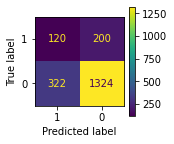

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
0,0.271493,0.375,0.314961,0.734486,0.620125,0.141238,"[0.6, 0.646]"


In [11]:
y_valid = df['mortal_admin']
y_test_proba    = df['mort_prob']
y_test_predict  = df['curb_mortality']

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None)
plt.show()
display(df_results_valid)


In [12]:
#################################################################
# curb65 from INTERPOLATED DATA
#################################################################
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20.pickle','rb')).drop(columns = 'no_sample_series')
print(X_data_19_20.columns)
X_data_19_20.head(4)

Index(['admission_id', 'rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp',
       'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'CREA', 'UREA', 'K',
       'GFR', 'WBC', 'PLT', 'HCT', 'HGB', 'RBC', 'MCH', 'MCV', 'NEUAB',
       'TLYMAB', 'EOSAB', 'MONAB', 'BASAB', 'ALB', 'ALP', 'BILI', 'sex',
       'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb',
       'Mortality'],
      dtype='object')


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,Mortality
0,58578756,20.000000,2.0,110.000000,38.400000,147.000000,92.000000,97.000000,0.0,0.0,...,0.080000,45.000000,137.000000,12.00000,-1.0,0.0,59.0,6.0,1.0,0.0
1,58578756,19.619047,2.0,108.190476,38.342857,145.761905,90.666667,96.904762,0.0,0.0,...,0.080000,45.000000,137.000000,12.00000,-1.0,0.0,59.0,6.0,1.0,0.0
2,58578756,19.238094,2.0,106.380952,38.285714,144.523810,89.333333,96.809524,0.0,0.0,...,0.079375,44.958333,137.072917,11.96875,-1.0,0.0,59.0,6.0,1.0,0.0
3,58578756,18.857143,2.0,104.571429,38.228571,143.285714,88.000000,96.714286,0.0,0.0,...,0.078125,44.875000,137.218750,11.90625,-1.0,0.0,59.0,6.0,1.0,0.0


In [13]:
def compute_CUBR65(adm_age, adm_conf, adm_rr, adm_urea, adm_sbp, adm_dbp):
    CURB_score = 0
    if adm_age  >= 65: CURB_score = CURB_score + 1
    if adm_conf >= 8: CURB_score = CURB_score + 1
    if adm_rr   >= 30: CURB_score = CURB_score + 1
    if adm_urea >= 7: CURB_score = CURB_score + 1
    if (adm_sbp <= 90) or (adm_dbp <= 60): CURB_score = CURB_score + 1
    return CURB_score
t = time.time()
errors = []
dict_predict_curb = {}
for admin in df['admission_id'].tolist():
    eobs_admin = X_data_19_20[X_data_19_20['admission_id'] == admin]
    if len(eobs_admin) == 0: 
        pred_curb = np.nan
        errors.append(admin)
    else:
        age = eobs_admin.iloc[0]['age_at_admin']
        cnf = eobs_admin.iloc[0]['Confusion']
        rr_ = eobs_admin.iloc[0]['rr']
        ure = eobs_admin.iloc[0]['UREA']
        sbp = eobs_admin.iloc[0]['sbp']
        dbp = eobs_admin.iloc[0]['dbp']
        
        pred_curb = compute_CUBR65(age, cnf, rr_, ure, sbp, dbp)
    dict_predict_curb[admin] = pred_curb
        
df['pred_CURB65_interpolated'] = df['admission_id'].apply(lambda x: dict_predict_curb[x])
display(df.head(4))
print("time elapsed:", time.time()-t)

,admission_id,curb65_score,mortal_admin,curb_mortality,mort_prob,pred_CURB65_interpolated
0,82152111,1.0,0,0,0.032,NaN
1,84563994,1.0,1,0,0.032,NaN
2,21350087,1.0,0,0,0.032,1.0
3,65992687,3.0,0,1,0.170,3.0


time elapsed: 99.9532687664032


In [14]:
df_curb65 = df.copy()
df_= df[~df['pred_CURB65_interpolated'].isna()].copy()
print(len(df['admission_id'].tolist()))
print(len(errors))
print(len(df_))
df.head(4)

1966
1080
886


,admission_id,curb65_score,mortal_admin,curb_mortality,mort_prob,pred_CURB65_interpolated
0,82152111,1.0,0,0,0.032,NaN
1,84563994,1.0,1,0,0.032,NaN
2,21350087,1.0,0,0,0.032,1.0
3,65992687,3.0,0,1,0.170,3.0


In [15]:
#################################################################
# curb65 from RAW DATA
#################################################################

path = r'/home/d/dlr10/Documents/01_Preprocessing/00_Data_2019_2020/DataFrame_pickles'
eobs_19_20 = pickle.load(open(path + r'/df_eobs_oxygen_2019_2020_v2.pickle','rb'))[0]
haem_19_20 = pickle.load(open(path + r'/df_haematology_v1.pickle','rb'))[0]

In [16]:
eobs_19_20.head(2)

,admission_id,patient_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
286091,99645131,18026138,2021-11-25 09:04:56,0.0,20.0,0,85.0,36.1,18956.378426,166.0,69.0
286094,99645131,18026138,2021-11-25 11:13:23,0 days 02:08:27,19.0,1,82.0,36.0,18956.467627,189.0,58.0


In [17]:
t = time.time()
errors = []
dict_predict_curb_raw = {}
for admin in df_['admission_id'].tolist():
    pati_admin = X_data_19_20[X_data_19_20['admission_id'] == admin]
    eobs_admin = eobs_19_20[eobs_19_20['admission_id'] == admin]
    haem_admin = haem_19_20[haem_19_20['admission_id'] == admin]
    if len(eobs_admin) == 0: 
        pred_curb = np.nan
        errors.append(admin)
    else:
        age = pati_admin.iloc[0]['age_at_admin']
        #cnf = eobs_admin.iloc[0]['Confusion']
        rr_ = eobs_admin.iloc[0]['rr']
        ure = haem_admin.iloc[0]['UREA']
        sbp = eobs_admin.iloc[0]['sbp']
        dbp = eobs_admin.iloc[0]['dbp']
        
        pred_curb = compute_CUBR65(age, 0, rr_, ure, sbp, dbp)
    dict_predict_curb_raw[admin] = pred_curb
    #break
        
df_['pred_CURB65_interpolated_raw'] = df_['admission_id'].apply(lambda x: dict_predict_curb_raw[x])
display(df_.head(4))
print("time elapsed:", time.time()-t)

,admission_id,curb65_score,mortal_admin,curb_mortality,mort_prob,pred_CURB65_interpolated,pred_CURB65_interpolated_raw
2,21350087,1.0,0,0,0.032,1.0,1
3,65992687,3.0,0,1,0.170,3.0,3
4,91595306,1.0,1,0,0.032,2.0,1
6,92109998,3.0,0,1,0.170,3.0,3


time elapsed: 48.10813117027283


##########################################################################
PREDICTION INTERPOLATED DATA
##########################################################################
0.8958333333333334
0.7777777777777778
0.732484076433121
0.5277777777777778
0.2564102564102564
0.0


,0,1,2,3,4,5
0,86,9,1,0,0,0
1,13,168,26,9,0,0
2,3,49,230,30,2,0
3,0,8,93,114,1,0
4,0,0,12,17,10,0
5,0,0,1,2,2,0


##########################################################################
PREDICTION RAW DATA
##########################################################################
0.8958333333333334
0.8148148148148148
0.7356687898089171
0.5277777777777778
0.28205128205128205
0.0


,0,1,2,3,4,5
0,86,10,0,0,0,0
1,14,176,16,10,0,0
2,3,52,231,26,2,0
3,0,8,94,114,0,0
4,0,1,10,17,11,0
5,0,0,1,2,2,0


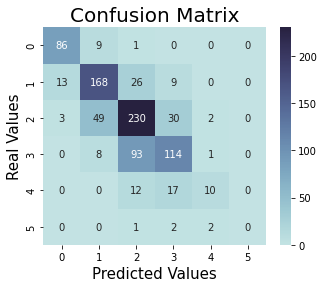

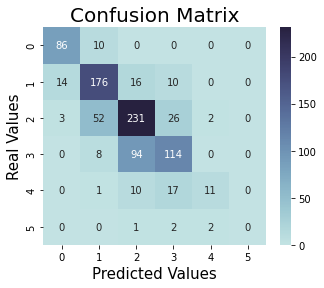

In [18]:
import seaborn as sns
print('##########################################################################')
print('PREDICTION INTERPOLATED DATA')
print('##########################################################################')
Y_valid   = df_['curb65_score']
y_predict = df_['pred_CURB65_interpolated']

cm = metrics.confusion_matrix(Y_valid, y_predict)
cm_df = pd.DataFrame(cm, index = range(6), columns = range(6))
#cm_df = 100*cm_df / len(Y_valid)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
c_map = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.heatmap(cm_df, annot=True, cmap =c_map,fmt='g')
plt.title('Confusion Matrix', fontsize = 20)
plt.ylabel('Real Values', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 15)
plt.plot()

for i in range(6):
    print(cm_df.iloc[i,i]/cm_df.iloc[i].sum())
display(cm_df)

##########################################################################
print('##########################################################################')
print('PREDICTION RAW DATA')
print('##########################################################################')
Y_valid   = df_['curb65_score']
y_predict = df_['pred_CURB65_interpolated_raw']

cm = metrics.confusion_matrix(Y_valid, y_predict)
cm_df = pd.DataFrame(cm, index = range(6), columns = range(6))
#cm_df = 100*cm_df / len(Y_valid)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
c_map = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.heatmap(cm_df, annot=True, cmap =c_map,fmt='g')
plt.title('Confusion Matrix', fontsize = 20)
plt.ylabel('Real Values', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 15)
plt.plot()
for i in range(6):
    print(cm_df.iloc[i,i]/cm_df.iloc[i].sum())
display(cm_df)


In [19]:
####################################################
# VALIDATION TO TIME SERIES MODEL GRU
####################################################
# ============================================================================
##############################################################################
##############################################################################
# IMPORT ALL TIME PACKAGES
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle, time, random, sys, warnings
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves
##############################################################################
# IMPORT DEEP LEARNING PACKAGES
##############################################################################

from sklearn.model_selection import cross_val_score, StratifiedKFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, accuracy_score
LeakyReLU = LeakyReLU(alpha=0.1)

from bayes_opt import BayesianOptimization


pd.set_option("display.max_columns", None)


# ENCODING FUNCTIONS
##############################################################################

# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
##############################################################################
# PLOTTING FUNCTIONS 
##############################################################################
def history_plots_(history, SAVE = 0, name = ''):
    auc_keys = [x for x in history.history.keys() if 'auc' in x]
    loss = history.history["loss"];     val_loss = history.history["val_loss"]
    acc  = history.history["accuracy"]; val_acc  = history.history["val_accuracy"]
    auc  = history.history[auc_keys[0]];      val_auc = history.history[auc_keys[1]]
    epochs  = range(1, len(acc) + 1)
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (8,4))
    ax0.plot(epochs, loss, "bo", label="Training Loss")
    ax0.plot(epochs, val_loss, "b", label="Validation Loss")
    ax0.set_title("Train-val Loss")
    ax1.plot(epochs, acc, "bo", label="Training Accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation Accuracy")
    ax1.set_title("Train-val Accuracy")
    ax2.plot(epochs, auc, "bo", label="Training AUC")
    ax2.plot(epochs, val_auc, "b", label="Validation AUC")
    ax2.set_title("Train-val AUC")
    plt.legend()
    if SAVE == 1: plt.savefig(name, transparent = True, bbox_inches = "tight")
    plt.show()
# ============================================================================

t_tot = time.time()
# ##############
# 1. LOAD DATA ---------------------------------------------------------------
# ============================================================================
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
df_patients_16_18, df_admissions_16_18, df_eobs_16_18 = load_fn.Load_data()
df_patients_19_20, df_admissions_19_20, df_eobs_19_20 = load_fn.Load_data('2019_2020')

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18.pickle','rb')).drop(columns = 'no_sample_series')
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20.pickle','rb')).drop(columns = 'no_sample_series')

X_data_19_20 = X_data_19_20[X_data_19_20['admission_id'].isin(df_['admission_id'].unique())]

# Dictionary of features and types --------
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
data_types = data_types.set_index('Variable').to_dict()['Type']

# List of features ------------------------
feat_list = X_data_16_18.columns.tolist()
feat_list = feat_list[1:-1]

# Resulst vaiables ------------------------
df_results_train = pd.DataFrame()
df_results_valid = pd.DataFrame()
dict_fpr_tpr = {}

print("Elapsed time loading data:", time.time()-t)


# ##############
# 2. PROCESSING DATA ---------------------------------------------------------
# ============================================================================
t = time.time()
### BALANCED DATA ####################################
random.seed(2)
X_0 = X_data_16_18[X_data_16_18['Mortality'] == 0]['admission_id'].unique().tolist()
X_1 = X_data_16_18[X_data_16_18['Mortality'] == 1]

list_X_0   = random.sample(range(len(X_0)),len(X_1['admission_id'].unique().tolist()))
X_0_2_adms = [X_0[pos] for pos in list_X_0]
X_0_2      = X_data_16_18[X_data_16_18['admission_id'].isin(X_0_2_adms)]

X_data_bal = pd.concat([X_1,X_0_2])

### SPLIT DATA #######################################
train_set = X_data_bal.copy()
valid_set = X_data_19_20.copy()

### ENCODING DATA ####################################
train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)

### SET DATA AS ARRAYs ###############################
num_samp_train = len(train_set['admission_id'].unique().tolist())
num_samp_valid = len(valid_set['admission_id'].unique().tolist())
num_features   = len(train_set_norm.columns.tolist())
num_time_samp  = 144
X_train    = np.array(train_set_norm).reshape((num_samp_train, num_time_samp, num_features ))
X_valid    = np.array(valid_set_norm).reshape((num_samp_valid, num_time_samp, num_features ))
df         = train_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))
y_train    = np.array([mort_dict[adm] for adm in train_set['admission_id'].unique().tolist()])

df         = valid_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))
y_valid   = np.array([mort_dict[adm] for adm in valid_set['admission_id'].unique().tolist()])
print("Elapsed time processing data:", time.time()-t)
# ============================================================================



Elapsed time loading data: 18.153325080871582
Elapsed time processing data: 1.7613747119903564


2022-11-24 18:46:39.095433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-11-24 18:46:39.095504: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 18:46:39.095560: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spectre13): /proc/driver/nvidia/version does not exist
2022-11-24 18:46:39.095970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

Confidence interval for the score: [0.781 - 0.846]


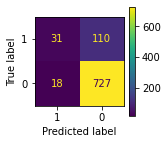

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC,name
0,0.632653,0.219858,0.326316,0.85553,0.813528,0.107703,"[0.78, 0.846]",Unbal_GRU


time elapsed 3.724299430847168


In [20]:
from tensorflow.keras.models import load_model
t = time.time()
path      = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/04_GRU_NN'
file_name = r'/Unbalanced_GRU_NN_history.pickle'
params_nn_, history= pickle.load(open(path + file_name,'rb'))
clf_model = load_model(path + '/Unbalanced_GRU_NN.h5')

y_test_proba    = clf_model.predict(X_valid)
y_test_predict  = FineTuning.adjusted_classes(y_test_proba, 0.5)

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None)
#lst_fpr_tpr.append(fpr_tpr)

#plt.savefig(name +'_valid_cm.png', transparent = True, bbox_inches = "tight")
plt.show()
df_results_valid['name'] = 'Unbal_GRU'
display(df_results_valid)
#final_df = pd.concat([final_df,df_results_valid])
print('time elapsed', time.time() - t)

Confidence interval for the score: [0.524 - 0.6]


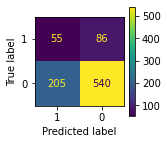

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
0,0.211538,0.390071,0.274314,0.671558,0.564006,0.141186,"[0.52, 0.6]"


In [29]:
y_valid = np.array(df_['mortal_admin'])
y_test_proba    = np.array(df_['mort_prob'])
y_test_predict  = np.array(df_['curb_mortality'])

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None, n_bt = 200)
plt.show()
display(df_results_valid)

In [30]:
df_

,admission_id,curb65_score,mortal_admin,curb_mortality,mort_prob,pred_CURB65_interpolated,pred_CURB65_interpolated_raw
2,21350087,1.0,0,0,0.032,1.0,1
3,65992687,3.0,0,1,0.170,3.0,3
4,91595306,1.0,1,0,0.032,2.0,1
6,92109998,3.0,0,1,0.170,3.0,3
7,24675133,2.0,1,0,0.030,2.0,2
...,...,...,...,...,...,...,...
1956,53941884,1.0,0,0,0.032,1.0,1
1957,80906301,2.0,0,0,0.030,2.0,2
1959,50103812,1.0,0,0,0.032,1.0,1
1960,42895943,3.0,0,1,0.170,3.0,3


In [ ]:
#y_valid = df_curb65['mortal_admin']
y_test_proba    = df_curb65['mort_prob']
y_test_predict  = df_curb65['curb_mortality']

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None)
plt.show()
display(df_results_valid)